In [1]:
# install.packages("LDlinkR")

In [2]:
library(qvalue)
library(dplyr)
library(LDlinkR)
library(ggplot2)

In [3]:
# v1: limix_qtl with two random effects (single cells, expanded K + CCt)

In [34]:
mydir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/limix_qtl_pipeline_Gtest/Gtest_10MOFA/"

In [35]:
res_file = paste0(mydir, "results_mj/top_qtl_results_all.txt")
res = read.csv(res_file, sep="\t")

In [36]:
nrow(res)
head(res,2)

[1] 864

snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,n_samples,n_e_samples,alpha_param,beta_param,rho,snp_chromosome,snp_position,assessed_allele,call_rate,maf,hwe_p,feature_id
19_57703077_T_G,9.758964e-06,-0.06163494,0.01393437,2.335648e-07,19,57702868,57724724,27598,99,1.859690,37.35126,0.8,19,57703077,G,1,0.4141414,1.00000000,ENSG00000083844
19_53816432_C_T,5.936559e-04,-0.06402515,0.01863979,6.353399e-03,19,53662466,53696639,27598,99,1.519646,74.48449,0.9,19,53816432,T,1,0.3939394,0.09246273,ENSG00000197497


In [7]:
res$global_corr_p_value = qvalue(res$empirical_feature_p_value)$qvalues

In [8]:
nrow(res[res$global_corr_p_value<0.05,])

[1] 238

In [9]:
############### old results (Cuomo*, Seaton*, McCarthy* et al Nat Comm 2020)

In [10]:
# load lead variant results sc stages (iPS, mesendo, defendo)
leads.ips = read.csv("/nfs/leia/research/stegle/acuomo/mean/day0/all_expts/leads.csv", row.names = 1)
leads.mes = read.csv("/nfs/leia/research/stegle/acuomo/mean/mesendo_est_June20/leads.csv", row.names = 1)
leads.defendo = read.csv("/nfs/leia/research/stegle/acuomo/mean/defendo_est_June20/leads.csv", row.names = 1)

In [11]:
# add differentiation stage information
leads.ips$stage = "ips"
leads.mes$stage = "mesendo"
leads.defendo$stage = "defendo"

In [12]:
# merge results
endo_eqtl = rbind(leads.ips, 
                 leads.mes,
                 leads.defendo)

In [13]:
head(endo_eqtl,2)

beta,beta_se,empirical_feature_p_value,p_value,snp_id,feature,global_corr_p_value,chrom,pos,ref_allele,...,permutation_1,permutation_2,permutation_3,permutation_4,permutation_5,permutation_6,permutation_7,permutation_8,permutation_9,stage
-1.0048674,0.08005311,3.631688e-34,3.851118e-36,5_149826526_C_T,ENSG00000164587_RPS14,2.880363e-30,5,149826526,C,...,0.5867415,0.56508683,0.6296458,0.004683908,0.5159591,0.7734028,0.6450821,0.6001209,0.9876646,ips
-0.9881017,0.08648823,2.432216e-26,3.147553e-30,11_57283988_C_T,ENSG00000134809_TIMM10,8.853960e-23,11,57283988,C,...,0.1093548,0.08194005,0.6897261,0.683497330,0.5137511,0.7877572,0.6064095,0.5419861,0.5654441,ips


In [14]:
# pick top SNP across stages (min p_value)

In [15]:
# order by p_value
endo_eqtl = endo_eqtl[order(endo_eqtl$p_value),]
nrow(endo_eqtl)
head(endo_eqtl,2)

[1] 32665

,beta,beta_se,empirical_feature_p_value,p_value,snp_id,feature,global_corr_p_value,chrom,pos,ref_allele,...,permutation_1,permutation_2,permutation_3,permutation_4,permutation_5,permutation_6,permutation_7,permutation_8,permutation_9,stage
6,-1.457854,0.1020245,9.536615e-26,2.553619e-46,4_39446549_G_A,ENSG00000163682_RPL9,1.260613e-22,4,39446549,G,...,0.02499141,0.6516389,0.4681722,0.3833344,0.05690061,0.02657527,0.2945979,0.02514148,0.7088325,ips
12,1.801311,0.1333499,3.391301e-21,1.399851e-41,7_55806087_G_T,ENSG00000226278_PSPHP1,2.241423e-18,7,55806087,G,...,0.10854778,0.0611202,0.3728356,0.2267340,0.60751447,0.24224812,0.6809891,0.47102673,0.2149549,ips


In [16]:
# select only one SNP per gene 
endo_eqtl = endo_eqtl[-which(duplicated(endo_eqtl$feature)),]
nrow(endo_eqtl)

[1] 10788

In [17]:
################ compare results

In [18]:
## first, check if lead SNP is the same (or in LD)

In [19]:
T = 0.1
## consider significant hits only
endo_eqtl = endo_eqtl[endo_eqtl$global_corr_p_value <= T,]
res = res[res$global_corr_p_value <= T,]

In [20]:
nrow(endo_eqtl)
nrow(res)

[1] 3079

[1] 293

In [21]:
endo_eqtl$feature_id = gsub("_.*","",endo_eqtl$feature)

In [22]:
cols = c("feature_id","snp_id")
df = inner_join(endo_eqtl[,c("stage",cols)], res[,cols], by = c("feature_id"), suffix=c(".old",".new"))

In [23]:
head(df)

stage,feature_id,snp_id.old,snp_id.new
ips,ENSG00000233927,19_8387207_G_A,19_8387207_G_A
ips,ENSG00000076924,19_7675917_C_G,19_7675917_C_G
ips,ENSG00000186230,19_57939619_C_T,19_57939619_C_T
ips,ENSG00000172687,19_21513408_G_A,19_21513408_G_A
ips,ENSG00000170892,19_54695163_T_C,19_54695163_T_C
ips,ENSG00000141994,19_5783634_T_C,19_5799037_C_T


In [20]:
# collect all SNPs
all_snps = unique(c(as.character(df$snp_id.old), as.character(df$snp_id.new)))
length(all_snps)
head(all_snps)

[1] 1524

[1] "19_8387207_G_A"  "19_7675917_C_G"  "19_57939619_C_T" "19_21513408_G_A"
[5] "19_54695163_T_C" "19_5783634_T_C"

In [59]:
snp_df = data.frame(snp=all_snps)
head(snp_df,2)

snp
19_8387207_G_A
19_7675917_C_G


In [60]:
nrow(snp_df)

[1] 188

In [260]:
# write.csv(snp_df, "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/limix_qtl_pipeline_Gtest/top_snps_to_compare.csv")

In [261]:
# load SNP correlation matrix
corrMatrix = read.csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/limix_qtl_pipeline_Gtest/top_snps_to_compare_corrs.csv", row.names=1)
colnames(corrMatrix) = gsub("X","",colnames(corrMatrix))

In [262]:
nrow(corrMatrix)

[1] 1517

In [263]:
corrMatrix[1:5,1:5]

,19_8387207_G_A,19_7675917_C_G,19_57939619_C_T,19_21513408_G_A,19_54695163_T_C
19_8387207_G_A,1.00000000,-0.12617660,-0.03007142,-0.15816291,0.09749598
19_7675917_C_G,-0.12617660,1.00000000,-0.11594338,-0.08269191,0.11289370
19_57939619_C_T,-0.03007142,-0.11594338,1.00000000,0.02868665,0.08602564
19_21513408_G_A,-0.15816291,-0.08269191,0.02868665,1.00000000,-0.04315027
19_54695163_T_C,0.09749598,0.11289370,0.08602564,-0.04315027,1.00000000


In [264]:
df$r = 0
df$r2 = 0

In [265]:
for (i in 1:nrow(df)){
    snp1 = as.character(df[i,"snp_id.old"])
    snp2 = as.character(df[i,"snp_id.new"])
    if (!(snp1 %in% colnames(corrMatrix)) | !(snp2 %in% colnames(corrMatrix))){next}
    df[i,"r"] = as.numeric(corrMatrix[snp1,snp2])
    df[i,"r2"] = df[i,"r"]**2
}

In [271]:
df

stage,feature_id,snp_id.old,snp_id.new,r,r2
ips,ENSG00000233927,19_8387207_G_A,19_8387207_G_A,1.00000000,1.000000000
ips,ENSG00000076924,19_7675917_C_G,19_7675917_C_G,1.00000000,1.000000000
ips,ENSG00000186230,19_57939619_C_T,19_57939619_C_T,1.00000000,1.000000000
ips,ENSG00000172687,19_21513408_G_A,19_21513408_G_A,1.00000000,1.000000000
ips,ENSG00000170892,19_54695163_T_C,19_54695163_T_C,1.00000000,1.000000000
ips,ENSG00000141994,19_5783634_T_C,19_5799037_C_T,0.95588461,0.913715391
ips,ENSG00000104808,19_49439728_C_T,19_49439728_C_T,1.00000000,1.000000000
ips,ENSG00000167641,19_38735804_A_T,19_38735480_G_A,0.83935473,0.704516361
mesendo,ENSG00000170889,19_54726870_C_G,19_54726870_C_G,1.00000000,1.000000000
ips,ENSG00000161265,19_36181046_T_C,19_36225999_T_C,0.71379471,0.509502887


In [266]:
T = 0.9
nrow(df)
c(nrow(df[df$r2>T,]), nrow(df[df$r2>T,])/nrow(df))

[1] 68

[1] 33.0000000  0.4852941

In [24]:
S1 = unlist(strsplit(as.character(df$snp_id.old),"_"))
snps = c()
for (i in seq(2,(length(S1)-1),4)){
   snps = c(snps,S1[i]) 
}
df$snp1 = paste0("chr19:",snps)

In [25]:
S2 = unlist(strsplit(as.character(df$snp_id.new),"_"))
snps = c()
for (i in seq(2,(length(S2)-1),4)){
   snps = c(snps,S2[i]) 
}
df$snp2 = paste0("chr19:",snps)

In [26]:
head(df)

stage,feature_id,snp_id.old,snp_id.new,snp1,snp2
ips,ENSG00000233927,19_8387207_G_A,19_8387207_G_A,chr19:8387207,chr19:8387207
ips,ENSG00000076924,19_7675917_C_G,19_7675917_C_G,chr19:7675917,chr19:7675917
ips,ENSG00000186230,19_57939619_C_T,19_57939619_C_T,chr19:57939619,chr19:57939619
ips,ENSG00000172687,19_21513408_G_A,19_21513408_G_A,chr19:21513408,chr19:21513408
ips,ENSG00000170892,19_54695163_T_C,19_54695163_T_C,chr19:54695163,chr19:54695163
ips,ENSG00000141994,19_5783634_T_C,19_5799037_C_T,chr19:5783634,chr19:5799037


In [27]:
nrow(df)

[1] 112

In [32]:
df$d = NA
for (i in 1:nrow(df)){
#     if (i %in% c(9,27,46,56,57,59,64)){next}
    if (i %in% c(9,27,51,63,65,68,76,96,112)){next}
#     if (i %in% c(9,32,72,86,90,91,103,107,109,110,116,121,122,129,130,131,132,142,145,147,163)){next}
    print(i)
    snp1 = as.character(df[i,"snp1"])
    snp2 = as.character(df[i,"snp2"])
    df[i,"d"] = as.numeric(LDpair(snp1, snp2, pop = "GBR", token = "f88ab64286ce")$d_prime)
}

[1] 1



LDlink server is working...



[1] 2



LDlink server is working...



[1] 3



LDlink server is working...



[1] 4



LDlink server is working...



[1] 5



LDlink server is working...



[1] 6



LDlink server is working...



[1] 7



LDlink server is working...



[1] 8



LDlink server is working...



[1] 10



LDlink server is working...



[1] 11



LDlink server is working...



[1] 12



LDlink server is working...



[1] 13



LDlink server is working...



[1] 14



LDlink server is working...



[1] 15



LDlink server is working...



[1] 16



LDlink server is working...



[1] 17



LDlink server is working...



[1] 18



LDlink server is working...



[1] 19



LDlink server is working...



[1] 20



LDlink server is working...



[1] 21



LDlink server is working...



[1] 22



LDlink server is working...



[1] 23



LDlink server is working...



[1] 24



LDlink server is working...



[1] 25



LDlink server is working...



[1] 26



LDlink server is working...



[1] 28



LDlink server is working...



[1] 29



LDlink server is working...



[1] 30



LDlink server is working...



[1] 31



LDlink server is working...



[1] 32



LDlink server is working...



[1] 33



LDlink server is working...



[1] 34



LDlink server is working...



[1] 35



LDlink server is working...



[1] 36



LDlink server is working...



[1] 37



LDlink server is working...



[1] 38



LDlink server is working...



[1] 39



LDlink server is working...



[1] 40



LDlink server is working...



[1] 41



LDlink server is working...



[1] 42



LDlink server is working...



[1] 43



LDlink server is working...



[1] 44



LDlink server is working...



[1] 45



LDlink server is working...



[1] 46



LDlink server is working...



[1] 47



LDlink server is working...



[1] 48



LDlink server is working...



[1] 49



LDlink server is working...



[1] 50



LDlink server is working...



[1] 52



LDlink server is working...



[1] 53



LDlink server is working...



[1] 54



LDlink server is working...



[1] 55



LDlink server is working...



[1] 56



LDlink server is working...



[1] 57



LDlink server is working...



[1] 58



LDlink server is working...



[1] 59



LDlink server is working...



[1] 60



LDlink server is working...



[1] 61



LDlink server is working...



[1] 62



LDlink server is working...



[1] 64



LDlink server is working...



[1] 66



LDlink server is working...



[1] 67



LDlink server is working...



[1] 69



LDlink server is working...



[1] 70



LDlink server is working...



[1] 71



LDlink server is working...



[1] 72



LDlink server is working...



[1] 73



LDlink server is working...



[1] 74



LDlink server is working...



[1] 75



LDlink server is working...



[1] 77



LDlink server is working...



[1] 78



LDlink server is working...



[1] 79



LDlink server is working...



[1] 80



LDlink server is working...



[1] 81



LDlink server is working...



[1] 82



LDlink server is working...



[1] 83



LDlink server is working...



[1] 84



LDlink server is working...



[1] 85



LDlink server is working...



[1] 86



LDlink server is working...



[1] 87



LDlink server is working...



[1] 88



LDlink server is working...



[1] 89



LDlink server is working...



[1] 90



LDlink server is working...



[1] 91



LDlink server is working...



[1] 92



LDlink server is working...



[1] 93



LDlink server is working...



[1] 94



LDlink server is working...



[1] 95



LDlink server is working...



[1] 97



LDlink server is working...



[1] 98



LDlink server is working...



[1] 99



LDlink server is working...



[1] 100



LDlink server is working...



[1] 101



LDlink server is working...



[1] 102



LDlink server is working...



[1] 103



LDlink server is working...



[1] 104



LDlink server is working...



[1] 105



LDlink server is working...



[1] 106



LDlink server is working...



[1] 107



LDlink server is working...



[1] 108



LDlink server is working...



[1] 109



LDlink server is working...



[1] 110



LDlink server is working...



[1] 111



LDlink server is working...



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 9 rows containing non-finite values (stat_bin).”

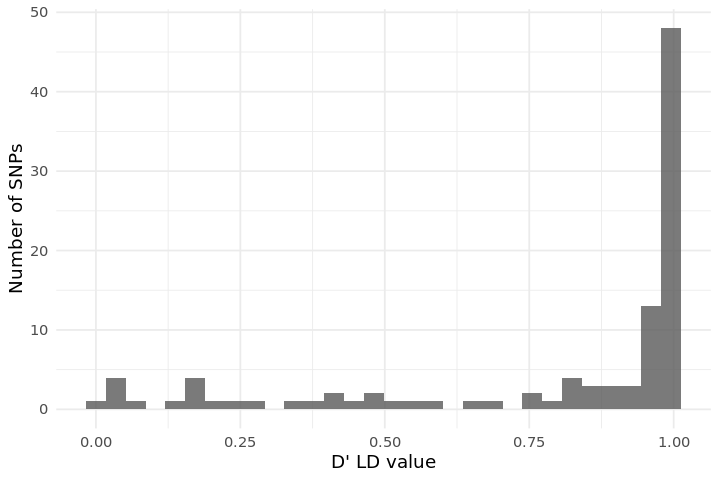

In [33]:
options(repr.plot.width=6, repr.plot.height=4)
p = ggplot(df, aes(x=d)) + geom_histogram(alpha = 0.8) + 
    xlab("D' LD value") + ylab("Number of SNPs") + theme_minimal()
p

In [315]:
S = unlist(strsplit(all_snps,"_"))
snps = c()
for (i in seq(2,(length(S)-1),4)){
   snps = c(snps,S[i]) 
}
snps = paste0("chr19:",snps)

In [316]:
head(all_snps)
head(snps)

[1] "19_8387207_G_A"  "19_7675917_C_G"  "19_57939619_C_T" "19_21513408_G_A"
[5] "19_54695163_T_C" "19_5783634_T_C"

[1] "chr19:8387207"  "chr19:7675917"  "chr19:57939619" "chr19:21513408"
[5] "chr19:54695163" "chr19:5783634"

In [319]:
# needed to request token by registering
LDmat = LDmatrix(snps, pop = "GBR", r2d = "d", token = "f88ab64286ce", file = FALSE)


LDlink server is working...



In [320]:
LDmat[1:5,1:5]

RS_number,rs10422590,rs10853988,rs9807887,rs2302307
rs10422590,1.000,0.161,0.139,0.193
rs10853988,0.161,1.000,0.265,0.248
rs9807887,0.139,0.265,1.000,0.041
rs2302307,0.193,0.248,0.041,1.000
rs12461613,0.006,0.062,0.033,0.177


In [321]:
ldMatrix = LDmat
rownames(ldMatrix) = ldMatrix$RS_number
ldMatrix$RS_number = c()
ldMatrix[1:5,1:5]

,rs10422590,rs10853988,rs9807887,rs2302307,rs12461613
rs10422590,1.000,0.161,0.139,0.193,0.006
rs10853988,0.161,1.000,0.265,0.248,0.062
rs9807887,0.139,0.265,1.000,0.041,0.033
rs2302307,0.193,0.248,0.041,1.000,0.177
rs12461613,0.006,0.062,0.033,0.177,1.000


In [322]:
write.csv(ldMatrix,"/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/limix_qtl_pipeline_Gtest/top_snps_to_compare_LD.csv")

In [323]:
df$d = 0
for (i in 1:nrow(df)){
    snp1 = as.character(df[i,"snp_id.old"])
    snp2 = as.character(df[i,"snp_id.new"])
    if (!(snp1 %in% colnames(ldMatrix)) | !(snp2 %in% colnames(ldMatrix))){next}
    df[i,"d"] = as.numeric(ldMatrix[snp1,snp2])
}

In [366]:
T = 0.9
nrow(df)
c(nrow(df[df$d>T,]), nrow(df[df$d>T,])/nrow(df))

[1] 68

[1] 57.0000000  0.8382353

In [ ]:
# for variants 19_5783634_T_C (rs2446210) and 19_5799037_C_T (rs2436531) and CEU reference
# D' value (from https://ldlink.nci.nih.gov/?tab=ldpair) is 0.9114, R2 is 0.8307
# Pearson's correlation as implemented here considering our samples only: r=0.9559, r2=0.9137

In [ ]:
# for variants 19_57930256_T_G (rs12982691) 19_57920134_C_T (rs12461155) and CEU reference
# D' value (from https://ldlink.nci.nih.gov/?tab=ldpair) is 1.0, R2 is 1.0
# Pearson's correlation as implemented here considering our samples only: r=0.9918, r2=0.9837

In [ ]:
# for variants 19_24069443_T_C (rs79301965) 19_24147099_A_G (rs4932737) and CEU reference
# D' value (from https://ldlink.nci.nih.gov/?tab=ldpair) is 0.9732, R2 is 0.7977
# Pearson's correlation as implemented here considering our samples only: r=0.7731, r2=0.5977

In [ ]:
# for variants 19_47805348_C_G (rs111514713) and 19_47882416_T_G (rs2016429) and CEU reference
# D' value (from https://ldlink.nci.nih.gov/?tab=ldpair) is 0.7155, R2 is 0.0293 ---- NO LD
# Pearson's correlation as implemented here considering our samples only: r=-0.1636, r2=0.0268

In [ ]:
# for variants 19_39917761_G_A (rs251860) and 19_40085507_A_G (rs592786) and CEU reference
# D' value (from https://ldlink.nci.nih.gov/?tab=ldpair) is 0.6444, R2 is 0.0671
# when using GBR as reference, D'= 0.9081, R2 = 0.1109
# Pearson's correlation as implemented here considering our samples only: r=0.0673, r2=0.0045

In [ ]:
# for variants 19_588516_A_G (rs10422590) 19_607735_A_G (rs10853988) and CEU reference
# D' value (from https://ldlink.nci.nih.gov/?tab=ldpair) is 0.2197, R2 is 0.0043 ---- NO LD (GBR too)
# Pearson's correlation as implemented here considering our samples only: r=-0.2427, r2=0.0589

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
